## DeepWideNet Architecture

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, concatenate
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import selu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

In [6]:
def wide_block(x, filters, name):
    f1, f2, f3 = filters
    prev_layer = x

    # wide shortcut
    conv_1x1_shortcut = Conv2D(filters=f1, kernel_size=(1, 1), activation=selu, padding='same')(prev_layer)
    conv_1x1_shortcut = BatchNormalization(axis=3)(conv_1x1_shortcut)

    # sub-deep path
    conv_5x5 = Conv2D(filters=f2, kernel_size=(5, 5), strides=(1, 1), activation=selu, padding='same')(prev_layer)
    conv_5x5 = BatchNormalization(axis=3)(conv_5x5)
    conv_3x3 = Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), activation=selu, padding='same')(conv_5x5)
    conv_3x3 = BatchNormalization(axis=3)(conv_3x3)

    # concatenation block 1
    sub_deep_block = concatenate([prev_layer, conv_3x3], axis=3)
    sub_deep_block = BatchNormalization(axis=3)(sub_deep_block)

    # concatenation block 2
    final_concat = concatenate([conv_1x1_shortcut, sub_deep_block], axis=3, name=name)

    return final_concat

In [14]:
input_layer = Input(shape=(156,156,3))

x = Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', activation=selu)(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

# conv_3x3
x = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same', activation=selu)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

x = wide_block(x,[256,64,64],'dw_1a')
x = wide_block(x,[256,64,64],'dw_1b')
x = wide_block(x,[256,64,64],'dw_1c')

x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = BatchNormalization()(x)

x = wide_block(x,[512,128,128],'dw_2a')
x = wide_block(x,[512,128,128],'dw_2b')
x = wide_block(x,[512,128,128],'dw_2c')

x = MaxPooling2D(pool_size=(7,7), strides=(2,2))(x)
x = BatchNormalization()(x)

# classification
x = Flatten()(x)
x = Dense(units=512, activation=selu)(x)
x = Dropout(0.5)(x)
exp_output = Dense(units=42, activation=softmax)(x)

exp_conv = Model(input_layer,exp_output)
exp_conv.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 156, 156, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 78, 78, 64)   4864        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_139 (Batch  (None, 78, 78, 64)  256         ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                            

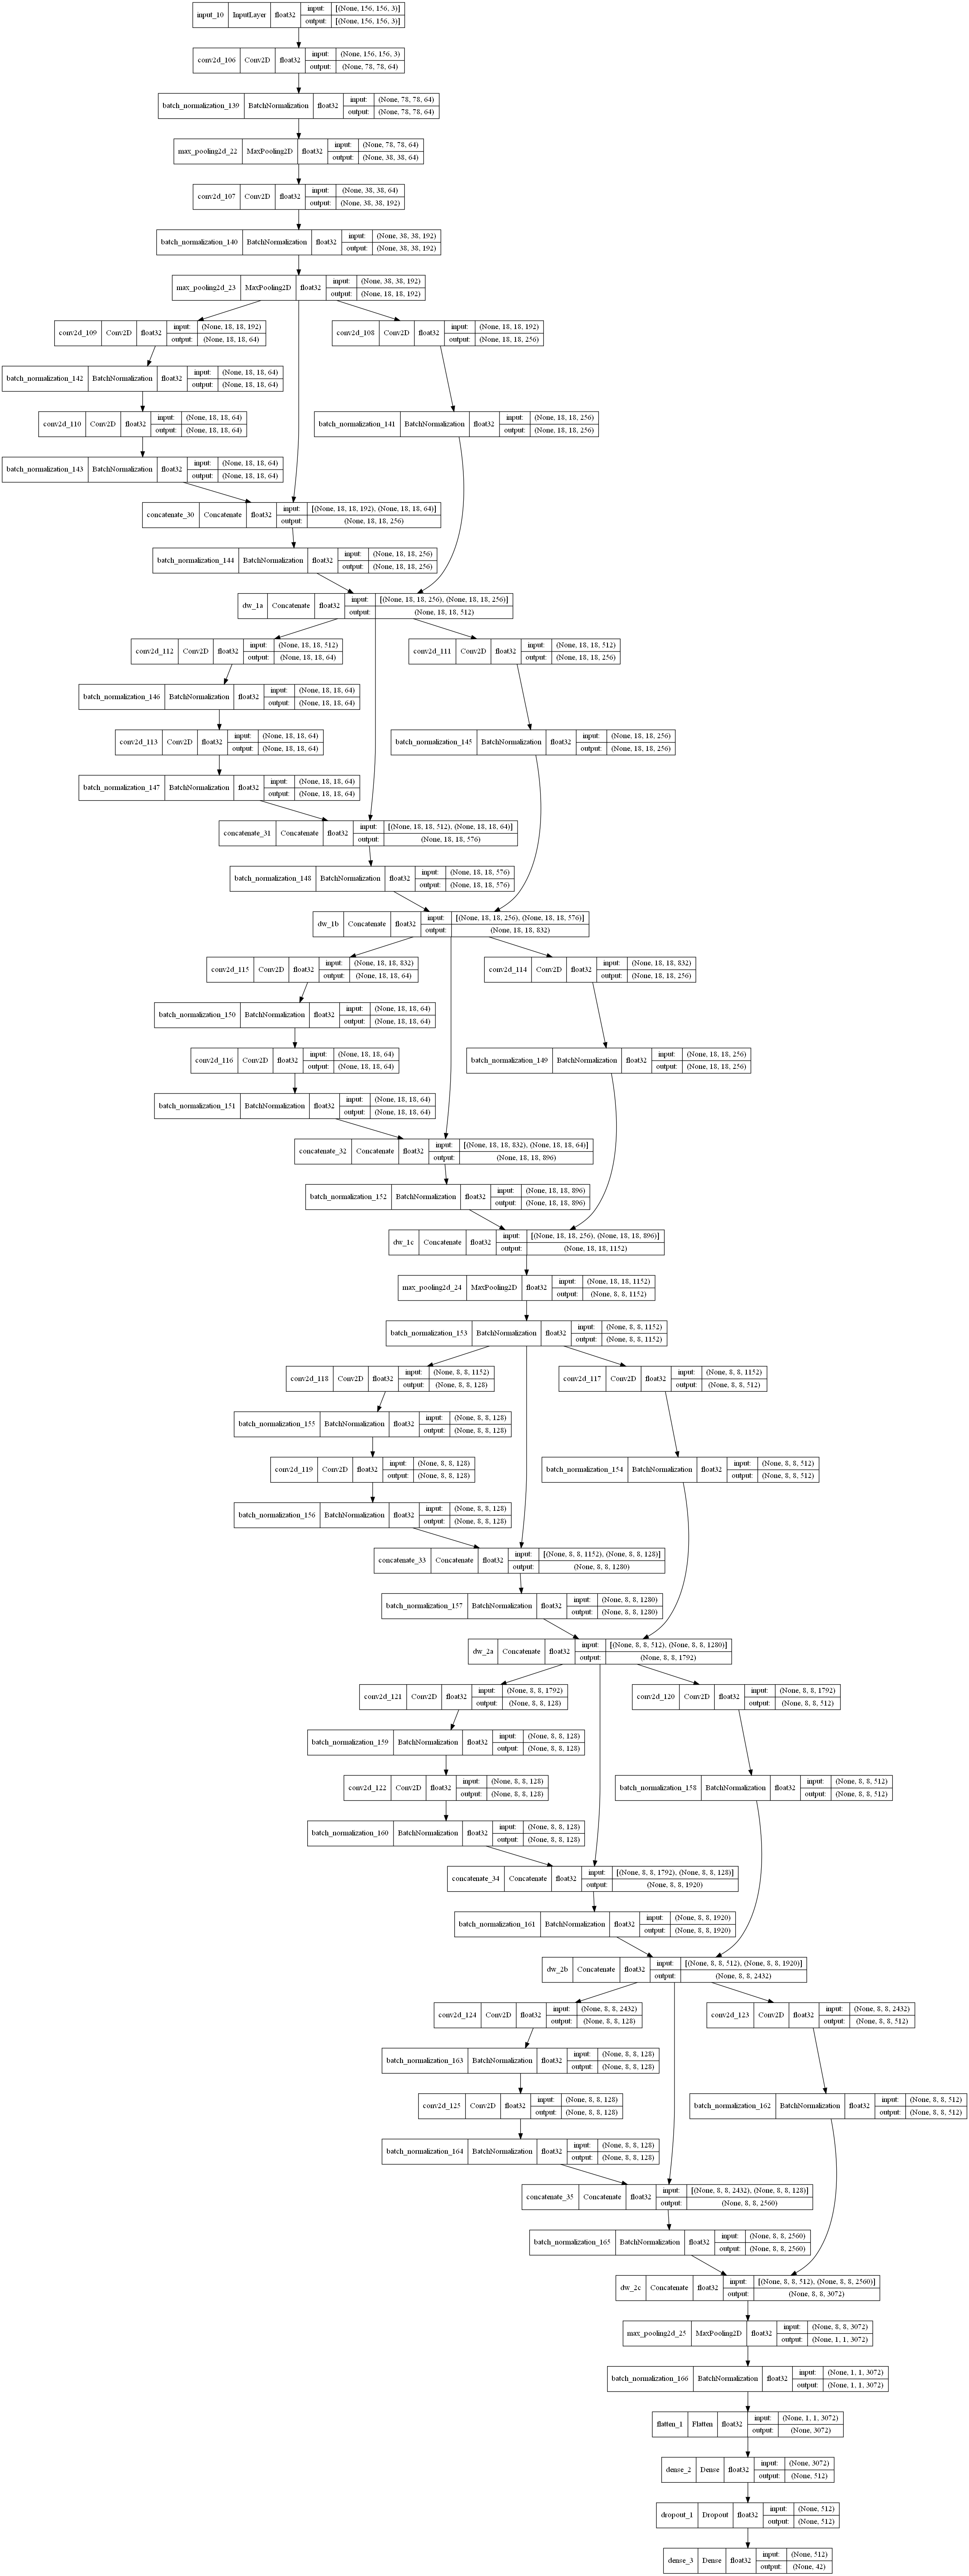

In [15]:
plot_model(model=exp_conv,
           to_file='DeepWideNet.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)